In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import logomaker

import glob
import re
from sklearn.decomposition import PCA

%matplotlib inline
plt.ion()

In [2]:
def extract_matrix(df, index, min_pos=None, max_pos=None):
    """
    Funciton to extract a matrix from a row of the dataframe
    """
    
    # Get list of all columns
    L = int(len([c for c in df.columns if '.' in c])/4)
    
    # Set min_pos
    if min_pos is None:
        min_pos = 0
        
    # Set max_pos
    if max_pos is None:
        max_pos = L
    
    # Create list of columns to extract
    cols = ['%02d.%s'%(i,c) for i in range(min_pos,max_pos) for c in 'ACGT']
    
    vec = df.loc[index,cols].values
    mat_arr = vec.reshape(-1,4)
    mat_df = pd.DataFrame(data=mat_arr, columns=list('ACGT'), dtype=float)
    return mat_df

In [3]:
# Load dataframe with all matrices
data_df = pd.read_csv('data_selected.txt', delimiter='\t', index_col=0)
print('data_df has %d rows.'%len(data_df))
data_df

data_df has 108 rows.


,lm,ars,mut,strain,exp,00.A,00.C,00.G,00.T,01.A,...,47.G,47.T,48.A,48.C,48.G,48.T,49.A,49.C,49.G,49.T
0,IM,ars317,"F485A, Y486A",m21,exp6,0.005840,0.003235,-0.033633,0.024558,-0.011041,...,-0.099109,0.133206,-0.040175,0.055051,-0.039498,0.024623,0.008800,-0.006307,0.009684,-0.012177
1,ER,ars317,"F485A, Y486A",m21,exp6,0.006325,-0.000532,-0.017159,0.011367,-0.005034,...,-0.097784,0.114822,-0.031425,0.045118,-0.030902,0.017209,0.016354,-0.001037,0.016828,-0.032146
2,IM,ars317,"F485A, Y486A",m21,exp7,0.007108,-0.002196,-0.022928,0.018016,-0.016403,...,-0.094059,0.133311,-0.035379,0.047618,-0.031899,0.019660,0.014209,-0.019739,0.018216,-0.012686
3,ER,ars317,"F485A, Y486A",m21,exp7,0.003310,-0.002844,-0.013020,0.012554,-0.020349,...,-0.090126,0.106316,-0.022390,0.039244,-0.027509,0.010655,0.019303,-0.012508,0.010904,-0.017698
4,IM,ars317,F485I,m3,exp6,-0.004045,0.005569,-0.014642,0.013118,-0.008004,...,-0.079839,0.111333,-0.029961,0.035882,-0.035030,0.029108,0.013203,-0.013798,0.004710,-0.004115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,ER,ars416,Y486Q,m1,exp7,0.004696,0.003284,0.000006,-0.007986,0.000589,...,-0.071807,0.100187,-0.009799,0.023625,-0.012448,-0.001378,0.033399,-0.012317,0.029282,-0.050364
104,IM,ars416,Y486Q,m1c1,exp9,-0.004067,0.001031,-0.002436,0.005473,0.002079,...,-0.112896,0.142464,-0.016034,0.045972,-0.015899,-0.014039,0.053347,-0.028282,0.045637,-0.070701
105,ER,ars416,Y486Q,m1c1,exp9,0.001505,0.001767,0.004366,-0.007638,0.004164,...,-0.124055,0.109687,-0.010071,0.021173,-0.010648,-0.000453,0.033394,-0.011913,0.025440,-0.046921
106,IM,ars416,Y486Q,m1c2,exp9,0.000685,-0.011873,0.009624,0.001564,0.005142,...,-0.088257,0.133616,-0.014247,0.033025,-0.010067,-0.008711,0.047386,-0.023742,0.041721,-0.065365


In [4]:
# Set data_cols and info_cols
data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]
L = int(len(data_cols)/4)

# Just to be super sure, fix the gauge of each matrix in each row
print('Fixing gauges just to be sure')
for i, row in data_df.iterrows():
    vec = row[data_cols].values
    mat = vec.reshape(L,4)
    mat = mat - mat.mean(axis=1)[:,np.newaxis]
    mat /= (mat**2).sum()
    row[data_cols] = mat.ravel()
    print('.', end='')
print('\nDone.')

Fixing gauges just to be sure
............................................................................................................
Done.


In [27]:
# Select order in which to display clones
strain_list = [
 'WT',
 'F485I',
 'Y486Q',
 'F485I, Y486Q',
 'F485A, Y486A',
 'F485Y, Y486F',
 'N489A', 
 'N489W', 
 'R478A',
 'R478K']

In [28]:
# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Asign each strain a color
strain_to_color_dict = dict([(s, colors[n]) for n,s in enumerate(strain_list)])

# Set font size
fontsize=7
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)

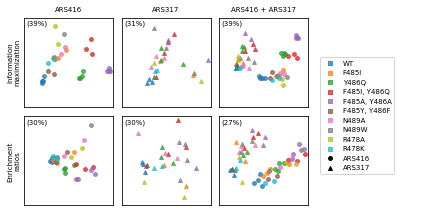

In [29]:
# Create figure
fig, axs = plt.subplots(2,4,figsize=[6,3])

# Set ars indices
ix_ars416 = data_df['ars']=='ars416'
ix_ars317 = data_df['ars']=='ars317'
size=15
alpha=.75

# Panel rows correspond to lm
for row_num, lm in enumerate(['IM','ER']):
    
    # Create initial indices
    ix_row = data_df['lm']==lm
    
    if lm=='IM':
        ylabel = 'Information\nmaximization'
    elif lm=='ER':
        ylabel = 'Enrichment\nratios'
    
    # Panel columns correspond to ars
    for col_num, ars in enumerate(['ars416','ars317','both']):
        
        # Set ax
        ax = axs[row_num, col_num]
        
        # Set indices and title
        if ars == 'ars416':
            ix = ix_row & ix_ars416
            title = f'ARS416'
        elif ars == 'ars317':
            ix = ix_row & ix_ars317
            title = f'ARS317'
        else:
            ix = ix_row & (ix_ars416 | ix_ars317)
            title = f'ARS416 + ARS317'
        
        # extract rows of dataframe 
        tmp_df = data_df[ix].copy()

        # Do PCA
        pca = PCA(n_components=2)
        X = tmp_df.loc[:,data_cols]
        pcs = pca.fit_transform(X)
        pca_cols = ['pc1','pc2']
        pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
        pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)
        
        # Compute pct variance explained
        pca_var = np.var(pcs, axis=0, ddof=0).sum()
        vec_var = np.var(X, axis=0, ddof=0).sum()
        pct_var_explained = 100*pca_var/vec_var

        # Dummy stuff for legend
        for strain in strain_list:
            color = strain_to_color_dict[strain]
            ax.scatter(x=[0], y=[0], color=color, label=strain, s=size, marker='s', alpha=alpha)
        ax.scatter(x=[0], y=[0], color='k', label='ARS416', s=size, marker='o')
        ax.scatter(x=[0], y=[0], color='k', label='ARS317', s=size, marker='^')
        ax.scatter(x=[0], y=[0], color='white', s=2*size, marker='s', alpha=1)
            
        # Plot strain by strain
        for i, strain in enumerate(strain_list):
            # Restrict df to chosen strain
            indices = (pca_df['mut']==strain) 
            tmp2_df = pca_df.loc[indices,:]

            xs = tmp2_df['pc1']
            ys = tmp2_df['pc2']
            ix = tmp2_df['ars']=='ars416'

            # Plot 416 points
            color = strain_to_color_dict[strain]
            if sum(ix) > 0:
                ax.scatter(x=xs[ix],y=ys[ix], 
                           color=color,
                           marker='o', s=size, alpha=alpha)

            # Plot 317 points
            if sum(~ix) > 0:
                ax.scatter(x=xs[~ix],y=ys[~ix], 
                           color=color,
                           marker='^', s=size, alpha=alpha)

        # Set lims
        xs = pca_df['pc1'].values
        ys = pca_df['pc2'].values
        rmax = max(np.sqrt(xs**2+ys**2))
        lims = np.array([-rmax, rmax])
        xlims = 1.05*lims
        ylims = 1.05*lims
        
        if col_num==0:
            ax.set_ylabel(ylabel)

        # Style plot
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

        if row_num==0:
            ax.set_title(title)
        
        # Show pct variance explained
        x = xlims[0] + .03*(xlims[1]-xlims[0])
        y = ylims[1] - .03*(ylims[1]-ylims[0])
        ax.text(x=x, y=y, s='(%d%%)'%pct_var_explained, 
                horizontalalignment='left', 
                verticalalignment='top')        
    
axs[0,3].axis('off')
axs[1,3].axis('off')
plt.tight_layout(w_pad=-2)
axs[0,2].legend(loc='center left', ncol=1, bbox_to_anchor=(1.1,-.1))

plt.savefig('pca.pdf')

In [36]:
.8*6

4.800000000000001

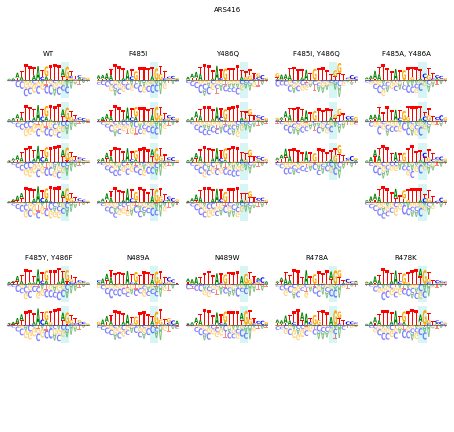

In [34]:
# Draw motifs from ARS416 
num_cols = 5
num_reps_per_mut = 4
fig, axs = plt.subplots(2*(num_reps_per_mut+1), num_cols, figsize=[6.5,6])

# Turn all axes off by default
for ax in axs.ravel():
    ax.axis('off')

# Set ars indices
ix_ars416 = (data_df['ars']=='ars416')

ylims = [-.3,.3]
        
for mut_num, mut in enumerate(strain_list):
    
    # Extract rows from data_df
    ix = ix_ars416 & (data_df['mut']==mut) & (data_df['lm']=='IM')
    tmp_df = data_df[ix]
    
    # Iterate over rows
    for rep_num in range(num_reps_per_mut):
        
        # Compute row and column
        col_num = mut_num%num_cols
        row_num = rep_num + (num_reps_per_mut+1)*(mut_num//num_cols) + 1
        ax = axs[row_num, col_num]
        
        # Set title of column 
        if rep_num==0:
            ax.set_title(f'{mut}')
        
        # Show logo if there is one
        if len(tmp_df) > rep_num:
            ax.axis('on')
            name = tmp_df.index[rep_num]
            mat_df = extract_matrix(tmp_df, name, min_pos=15, max_pos=35)
            logo = logomaker.Logo(df=mat_df, ax=ax, show_spines=False, fade_below=.5)
            ax.set_ylim(ylims)
            logo.highlight_position_range(pmin=13, pmax=14, color='paleturquoise', alpha=.5)
            ax.set_yticks([])
            ax.set_xticks([])
        
plt.tight_layout(h_pad=-1, w_pad=1, pad=2)
fig.text(x=.5, y=1, s='ARS416', horizontalalignment='center', verticalalignment='top')
fig.savefig('logos_ars416.pdf')

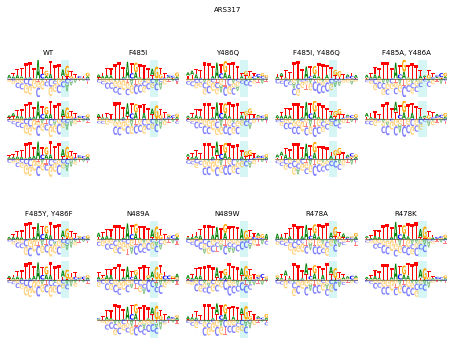

In [37]:
# Draw motifs from ARS317
num_cols = 5
num_reps_per_mut = 3
fig, axs = plt.subplots(2*(num_reps_per_mut+1), num_cols, figsize=[6.5,4.8])

# Turn all axes off by default
for ax in axs.ravel():
    ax.axis('off')

ylims = [-.3,.3]
        
for mut_num, mut in enumerate(strain_list):
    
    # Extract rows from data_df
    ix = (data_df['ars']=='ars317') & (data_df['mut']==mut) & (data_df['lm']=='IM')
    tmp_df = data_df[ix]
    
    # Iterate over rows
    for rep_num in range(num_reps_per_mut):
        
        # Compute row and column
        col_num = mut_num%num_cols
        row_num = rep_num + (num_reps_per_mut+1)*(mut_num//num_cols) + 1
        ax = axs[row_num, col_num]
        
        # Set title of column 
        if rep_num==0:
            ax.set_title(f'{mut}')
        
        # Show logo if there is one
        if len(tmp_df) > rep_num:
            ax.axis('on')
            name = tmp_df.index[rep_num]
            mat_df = extract_matrix(tmp_df, name, min_pos=15, max_pos=35)
            logo = logomaker.Logo(df=mat_df, ax=ax, show_spines=False, fade_below=.5)
            ax.set_ylim(ylims)
            logo.highlight_position_range(pmin=13, pmax=14, color='paleturquoise', alpha=.5)
            ax.set_yticks([])
            ax.set_xticks([])
        
plt.tight_layout(h_pad=-1, w_pad=1, pad=2)
fig.text(x=.5, y=1, s='ARS317', horizontalalignment='center', verticalalignment='top')
fig.savefig('logos_ars317.pdf')